# Time-Series with ARIMA

### Goal

Forecast the number and types of disasters for upcoming months/years to support disaster management planning.

Download the [dataset here](https://www.kaggle.com/datasets/fema/federal-disasters/data).

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [2]:
df = pd.read_csv("../data/database.csv")
df.head()

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,Individual Assistance Program,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program
0,DR-1,Disaster,05/02/1953,GA,NaN,Tornado,Tornado,05/02/1953,05/02/1953,06/01/1954,Yes,No,Yes,Yes
1,DR-2,Disaster,05/15/1953,TX,NaN,Tornado,Tornado and Heavy Rainfall,05/15/1953,05/15/1953,01/01/1958,Yes,No,Yes,Yes
2,DR-3,Disaster,05/29/1953,LA,NaN,Flood,Flood,05/29/1953,05/29/1953,02/01/1960,Yes,No,Yes,Yes
3,DR-4,Disaster,06/02/1953,MI,NaN,Tornado,Tornado,06/02/1953,06/02/1953,02/01/1956,Yes,No,Yes,Yes
4,DR-5,Disaster,06/06/1953,MT,NaN,Flood,Floods,06/06/1953,06/06/1953,12/01/1955,Yes,No,Yes,Yes


In [3]:
df.shape

(46185, 14)

In [4]:
diff_date = df["Declaration Date"] != df["Start Date"]
diff_date.value_counts()

True     36458
False     9727
Name: count, dtype: int64

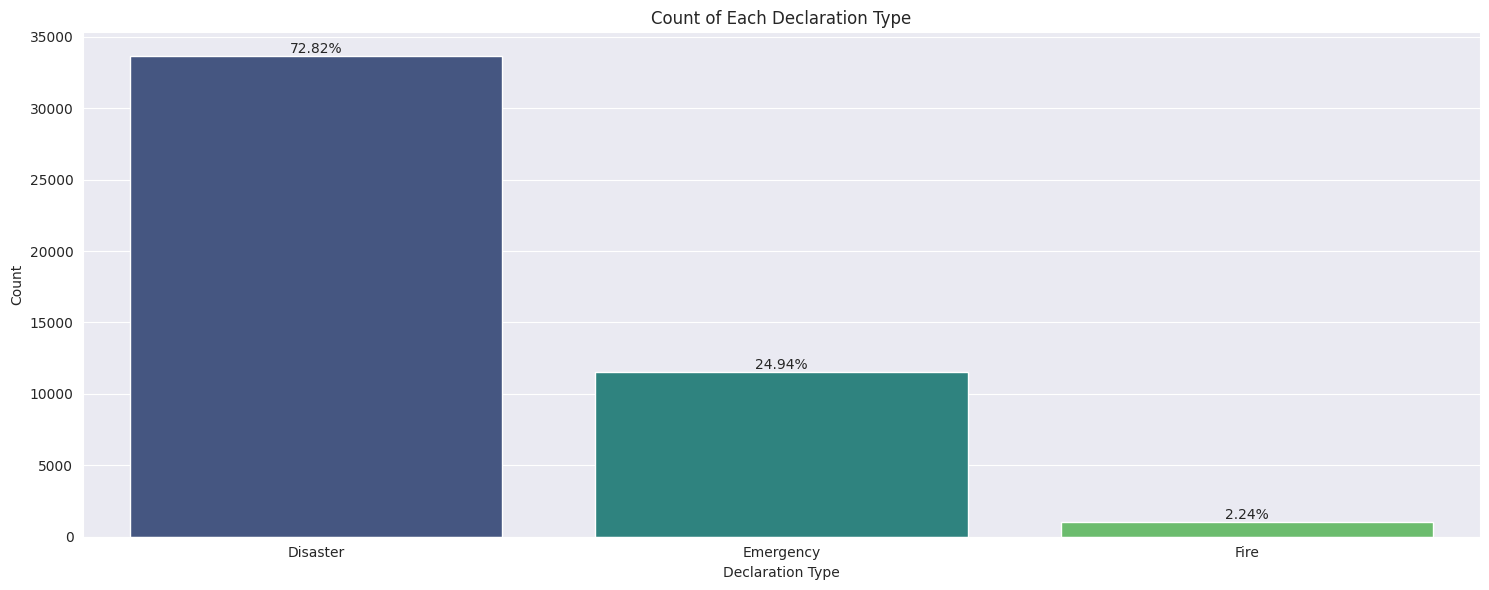

In [5]:
declaration_type_counts = df['Declaration Type'].value_counts()

total_count = declaration_type_counts.sum()
percentages = (declaration_type_counts / total_count) * 100

plt.figure(figsize=(15, 6))
ax = sns.barplot(x=declaration_type_counts.index, y=declaration_type_counts.values, hue=declaration_type_counts.index, palette='viridis')
plt.xlabel('Declaration Type')
plt.ylabel('Count')
plt.title('Count of Each Declaration Type')

for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.tight_layout();


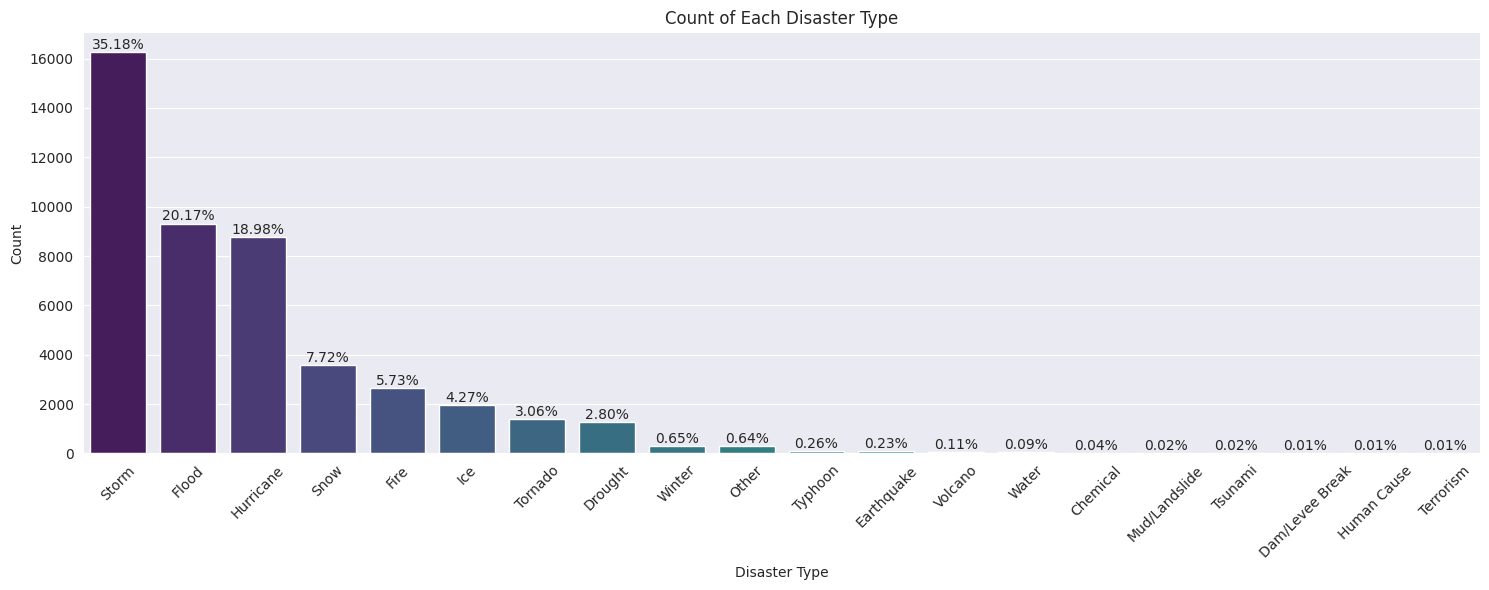

In [6]:
disaster_type_counts = df['Disaster Type'].value_counts()

total_count = disaster_type_counts.sum()
percentages = (disaster_type_counts / total_count) * 100

plt.figure(figsize=(15, 6))
ax = sns.barplot(x=disaster_type_counts.index, y=disaster_type_counts.values, hue=disaster_type_counts.index, palette='viridis')
plt.xlabel('Disaster Type')
plt.ylabel('Count')
plt.title('Count of Each Disaster Type')

for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45)  
plt.tight_layout();

In [8]:
# # Convert dates to datetime and set index
# df['Declaration Date'] = pd.to_datetime(df['Declaration Date'])
# df.set_index('Declaration Date', inplace=True)

# # Aggregate disaster counts by year
# count_of_disasters_df = df.resample('ME').size().reset_index(name='count_of_disaster')

# # Set 'Declaration Date' as index for the resampled data
# count_of_disasters_df.set_index('Declaration Date', inplace=True)

# # Ensure the time series data is from the 'count' column
# time_series_data = count_of_disasters_df['count_of_disaster']

# # Ensure the frequency is set correctly (monthly data in this case)
# time_series_data = time_series_data.asfreq('ME')

In [7]:
df['Declaration Date'] = pd.to_datetime(df['Declaration Date'])
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

df['Timestamp'] = df['Declaration Date']

# Aggregate the data to count the total disasters per date
count_df = df.groupby('Timestamp').agg(
    Total_Disasters=('Declaration Type', 'count')
).reset_index()

count_df.set_index('Timestamp', inplace=True)

# Resample the time series to daily frequency and drop missing days
daily_ts_data = count_df['Total_Disasters'].asfreq('D').dropna()


In [8]:
daily_ts_data.head()

Timestamp
1953-05-02    1.0
1953-05-15    1.0
1953-05-29    1.0
1953-06-02    1.0
1953-06-06    1.0
Name: Total_Disasters, dtype: float64

In [9]:
daily_ts_data.isna().sum()

0

In [10]:
daily_ts_data.dtype

dtype('float64')

In [ ]:
daily_ts_data.describe()

In [11]:
strictly_increasing = daily_ts_data.is_monotonic_increasing
print("Does Total_Disasters is in increasing order ?", strictly_increasing)

Does Total_Disasters is in increasing order ? False


Skewness: 8.49
Kurtosis: 116.59


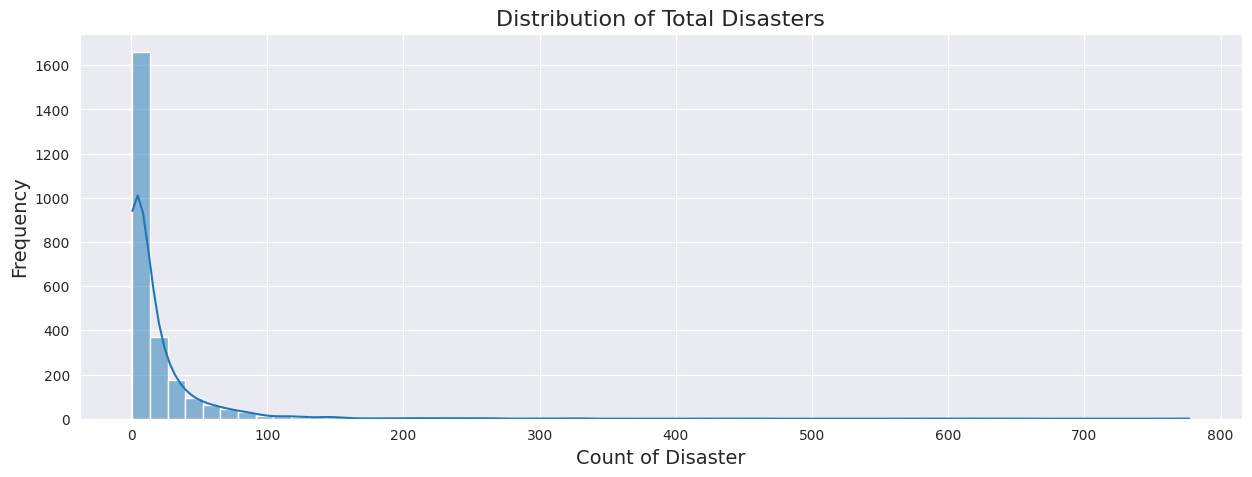

In [35]:
skewness = daily_ts_data.to_frame()['Total_Disasters'].skew()
kurtosis_value = daily_ts_data.to_frame()['Total_Disasters'].kurt()

print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis_value:.2f}")

plt.figure(figsize=(15, 5))
sns.histplot(daily_ts_data.to_frame()['Total_Disasters'], kde=True, bins=60)

plt.title('Distribution of Total Disasters', fontsize=16)
plt.xlabel('Count of Disaster', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.grid(True);

- The skewness of `Total_Disasters` is **8.49**, and the kurtosis is **116.59**, indicating that the distribution is **heavily right-skewed.**
- Additionally, the variable is **not normally distributed**.

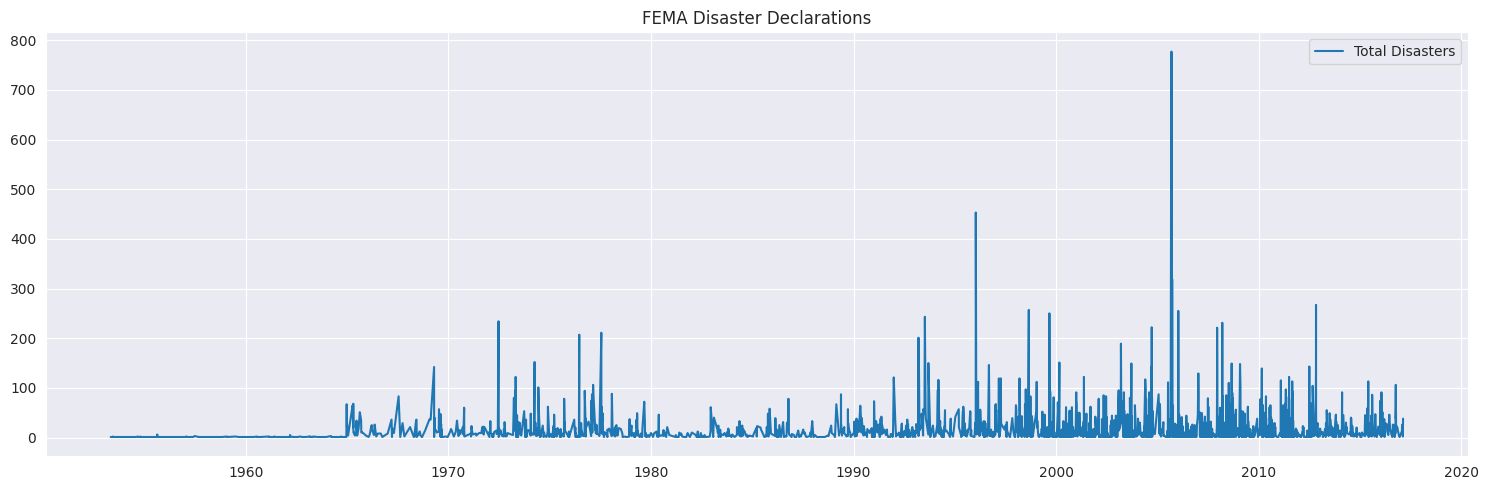

In [12]:
# Plot the time series data
plt.figure(figsize=(15, 5))
plt.plot(daily_ts_data, label='Total Disasters')
plt.title('FEMA Disaster Declarations')
plt.legend()
plt.tight_layout();

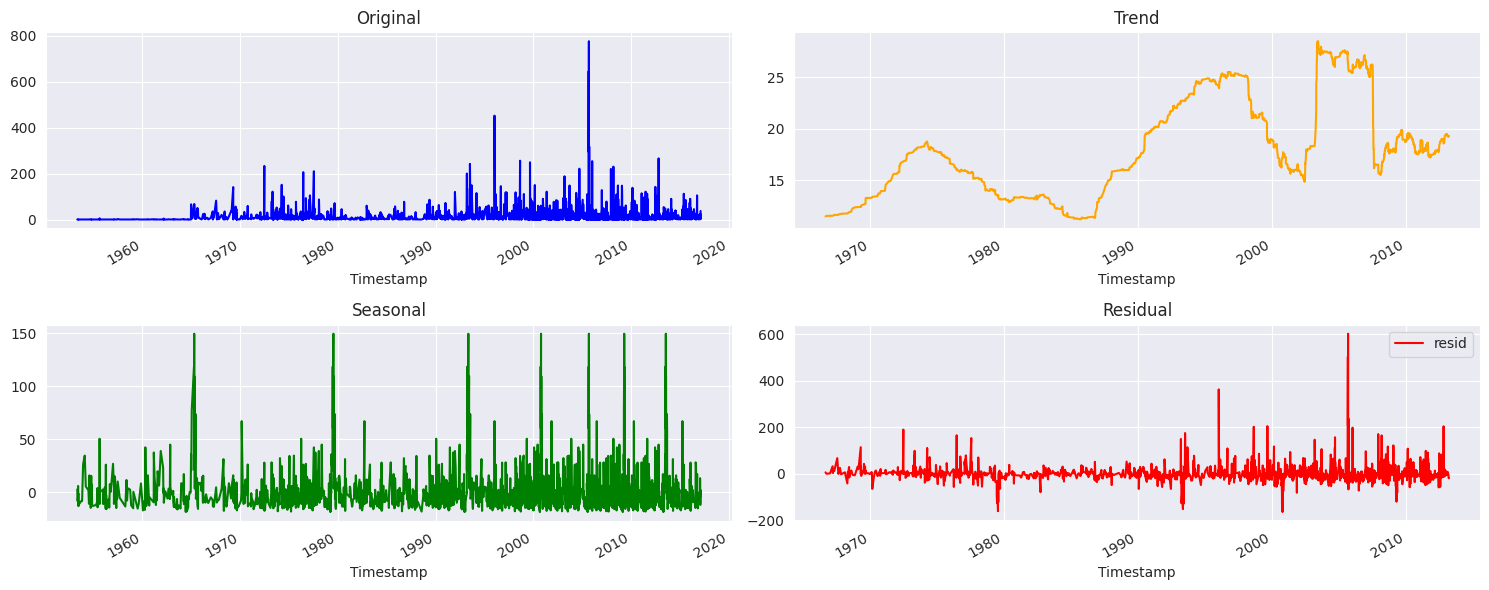

In [13]:
# Decompose
decomposition = sm.tsa.seasonal_decompose(daily_ts_data, model='additive', period=365)


fig, axes = plt.subplots(2, 2, figsize=(15, 6))

# Plot each component in a separate subplot
decomposition.observed.plot(ax=axes[0, 0], title='Original', color='blue')
decomposition.trend.plot(ax=axes[0, 1], title='Trend', color='orange')
decomposition.seasonal.plot(ax=axes[1, 0], title='Seasonal', color='green')
decomposition.resid.plot(ax=axes[1, 1], title='Residual', color='red')

plt.legend()
plt.tight_layout();

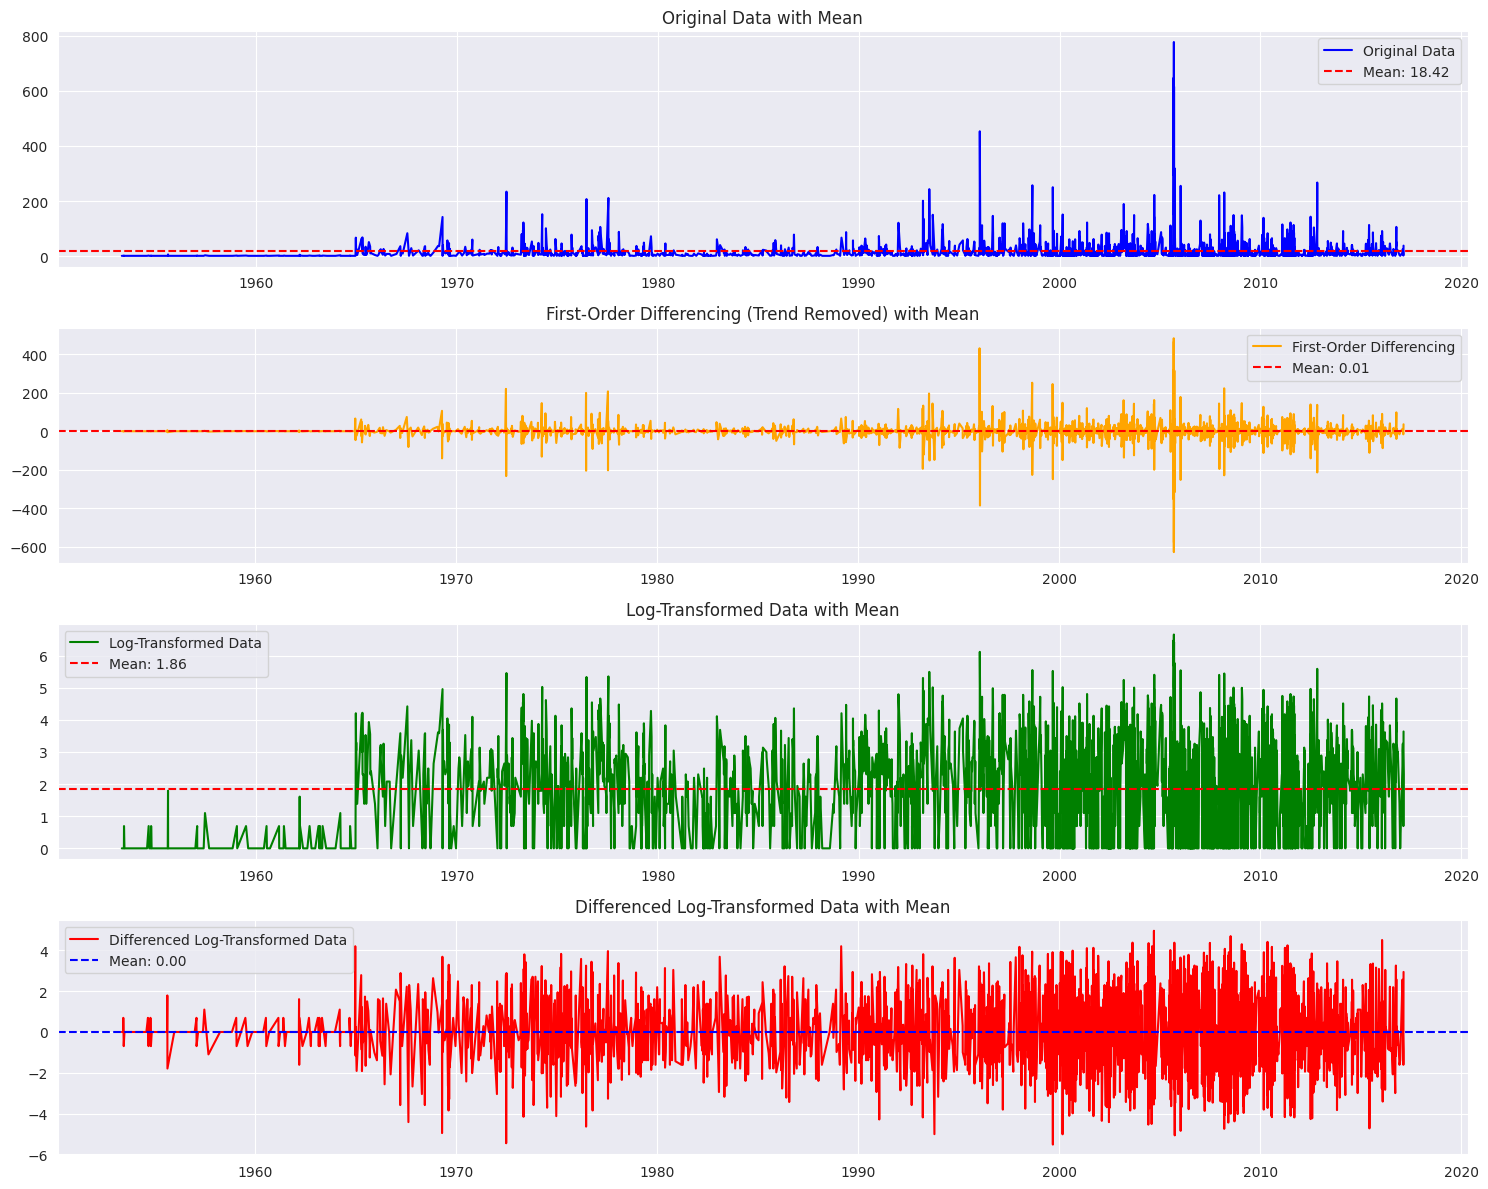

In [14]:
first_differenced = daily_ts_data.diff().dropna() # First Differenced Data

second_differenced = first_differenced.diff().dropna() # Second Differenced Data

log_transformed = np.log(daily_ts_data + 1e-5).replace(-np.inf, np.nan).dropna() # Log-Transformed Data

log_diff = log_transformed.diff().dropna() # Differenced Log-Transformed Data

# Calculate means for each transformation
original_mean = daily_ts_data.mean()
first_differenced_mean = first_differenced.mean()
second_differenced_mean = second_differenced.mean()
log_transformed_mean = log_transformed.mean()
log_diff_mean = log_diff.mean()

# Plot the Original Data with mean
plt.figure(figsize=(15, 12))
plt.subplot(4, 1, 1)
plt.plot(daily_ts_data, label="Original Data", color='blue')
plt.axhline(original_mean, color='red', linestyle='--', label=f"Mean: {original_mean:.2f}")
plt.title("Original Data with Mean")
plt.legend()

# Plot the First Differenced Data with mean
plt.subplot(4, 1, 2)
plt.plot(first_differenced, label="First-Order Differencing", color='orange')
plt.axhline(first_differenced_mean, color='red', linestyle='--', label=f"Mean: {first_differenced_mean:.2f}")
plt.title("First-Order Differencing (Trend Removed) with Mean")
plt.legend()

# Plot the Log-Transformed Data with mean
plt.subplot(4, 1, 3)
plt.plot(log_transformed, label="Log-Transformed Data", color='green')
plt.axhline(log_transformed_mean, color='red', linestyle='--', label=f"Mean: {log_transformed_mean:.2f}")
plt.title("Log-Transformed Data with Mean")
plt.legend()  

# Plot the Differenced Log-Transformed Data with mean
plt.subplot(4, 1, 4)
plt.plot(log_diff, label="Differenced Log-Transformed Data", color='red')
plt.axhline(log_diff_mean, color='blue', linestyle='--', label=f"Mean: {log_diff_mean:.2f}")
plt.title("Differenced Log-Transformed Data with Mean")
plt.legend()

plt.tight_layout();

### Stationary Check

#### Which Test Should We Choose: ADF or KPSS?

Choosing between the ADF and KPSS tests can sometimes be confusing. A practical approach is to apply both tests and cross-check their conclusions to confirm if the series is truly stationary. The following outcomes can help interpret the results:
- **Case 1:** Both tests conclude that the series is not stationary - The series is not stationary
- **Case 2:** Both tests conclude that the series is stationary - The series is stationary
- **Case 3:** KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- **Case 4:** KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


In [15]:
# ADF Test
def adf_test(timeseries):
    print("ADF Test:\n")
    print("Null Hypothesis (H0): The series has a unit root or is non-stationary.")
    print("Alternate Hypothesis (H1): The series has no unit root or is stationary.\n")
    print("Results of Dickey-Fuller Test:\n")
    adf_result = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(
        adf_result[0:4], index=["Test Statistic", "p-value", "Lags Used", "Observations Used"]
    )
    for key, value in adf_result[4].items():
        adf_output[f"Critical Value ({key})"] = value
    print(adf_output,'\n')
    
    if adf_output.iloc[1] < 0.05:  # Use .iloc[1] for the p-value
        print("Reject H0: The series is stationary.\n")
    else:
        print("Fail to Reject H0: The series is non-stationary.\n")
        

# KPSS Test
def kpss_test(timeseries):
    print("KPSS Test:\n")
    print("Null Hypothesis (H0): The series is trend stationary or has no unit root.")
    print("Alternate Hypothesis (H1): The series has a unit root (is non-stationary).\n")
    print("Results of KPSS Test:\n")
    kpss_result = kpss(timeseries, nlags="auto")
    kpss_output = pd.Series(
        kpss_result[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpss_result[3].items():
        kpss_output[f"Critical Value ({key})"] = value
    print(kpss_output,'\n')
    
    if kpss_output.iloc[1] < 0.05:  # Use .iloc[1] for the p-value
        print("Reject H0: The series is non-stationary.\n")
    else:
        print("Fail to Reject H0: The series is stationary.\n")


In [16]:
# Check stationarity with ADF Test
adf_test(daily_ts_data) 

ADF Test:

Null Hypothesis (H0): The series has a unit root or is non-stationary.
Alternate Hypothesis (H1): The series has no unit root or is stationary.

Results of Dickey-Fuller Test:

Test Statistic         -1.603150e+01
p-value                 6.050222e-29
Lags Used               3.000000e+00
Observations Used       2.503000e+03
Critical Value (1%)    -3.432965e+00
Critical Value (5%)    -2.862695e+00
Critical Value (10%)   -2.567385e+00
dtype: float64 

Reject H0: The series is stationary.



In [17]:
# Check stationarity with KPSS Test
kpss_test(daily_ts_data)

KPSS Test:

Null Hypothesis (H0): The series is trend stationary or has no unit root.
Alternate Hypothesis (H1): The series has a unit root (is non-stationary).

Results of KPSS Test:

Test Statistic            0.384710
p-value                   0.083746
Lags Used                23.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64 

Fail to Reject H0: The series is stationary.



Obervation of the ADF and KPSS Tests:

- **Based on the ADF Test, the series is stationary** because the p-value is less than the significance level of 0.05, leading to the rejection of the null hypothesis.
- **Based on the KPSS Test, the series is stationary** because the p-value is greater than the significance level of 0.05, leading to the failure to reject the null hypothesis.
- **Conclusion: The series is stationary.**

In [18]:
def diff_inv(series_diff, first_value):
    return np.cumsum(np.insert(series_diff, 0, first_value))


# Example of original series
original_series = pd.Series([100, 102, 105, 110, 115])

# Apply differentiation
series_diff = original_series.diff().dropna()

# Invert differentiation
first_value = original_series.iloc[0]
reconstructed_series = diff_inv(series_diff, first_value)

print("Original series:", original_series.values)
print("Differentiation series", series_diff)
print("Reconstructed series:", reconstructed_series)

Original series: [100 102 105 110 115]
Differentiation series 1    2.0
2    3.0
3    5.0
4    5.0
dtype: float64
Reconstructed series: [100. 102. 105. 110. 115.]


In [ ]:
# # Apply differencing to make the series stationary
# ts_data_diff = ts_data.diff().dropna()

In [ ]:
# # Recheck for strict stationarity.
# adf_test(ts_data_diff)
# print('----'*20) 
# kpss_test(ts_data_diff)

#### Determining $p$ and $q$ from PACF and ACF:

- `Cuts off`: The value drops abruptly to zero.
- `Tails off`: The value gradually decays towards zero, usually in an exponential way.

- Select $p$ based on significant spikes from the PACF plot. 
    - One clue is that the ACF plot decays more slowly.
- Select $q$ from ACF if this plot has a sharp cut-off after lag $q$. 
    - One clue is that the PACF plot decays more slowly.

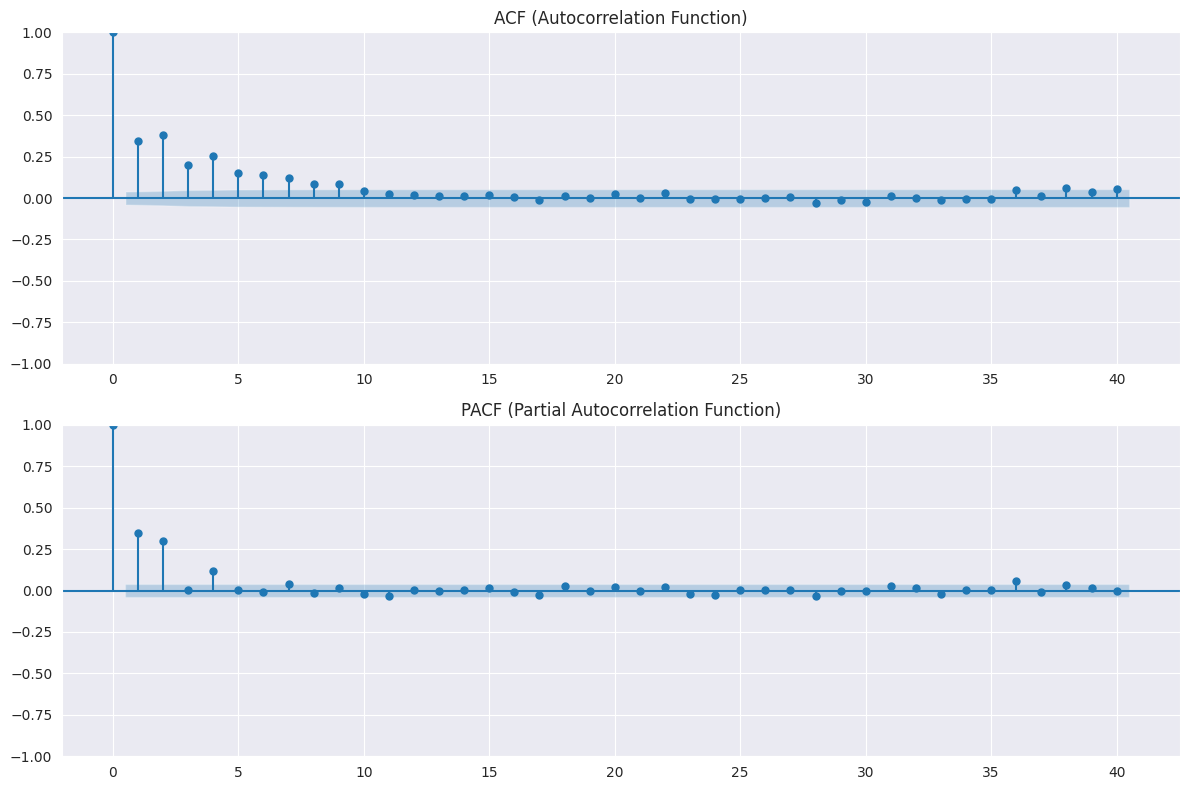

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF (Autocorrelation Function) with alpha=0.05 = 95% confidence interval
plot_acf(daily_ts_data, lags=40, alpha=0.05, ax=ax1)  
ax1.set_title('ACF (Autocorrelation Function)')

# Plot PACF (Partial Autocorrelation Function) with alpha=0.05 = 95% confidence interval
plot_pacf(daily_ts_data, lags=40, alpha=0.05, ax=ax2)  
ax2.set_title('PACF (Partial Autocorrelation Function)')

plt.tight_layout();

Dataset dimensions: (2507,)
Training data dimension: (2005, 1) - 79.98% of dataset
Actual data dimension: (502, 1) - 20.02% of dataset


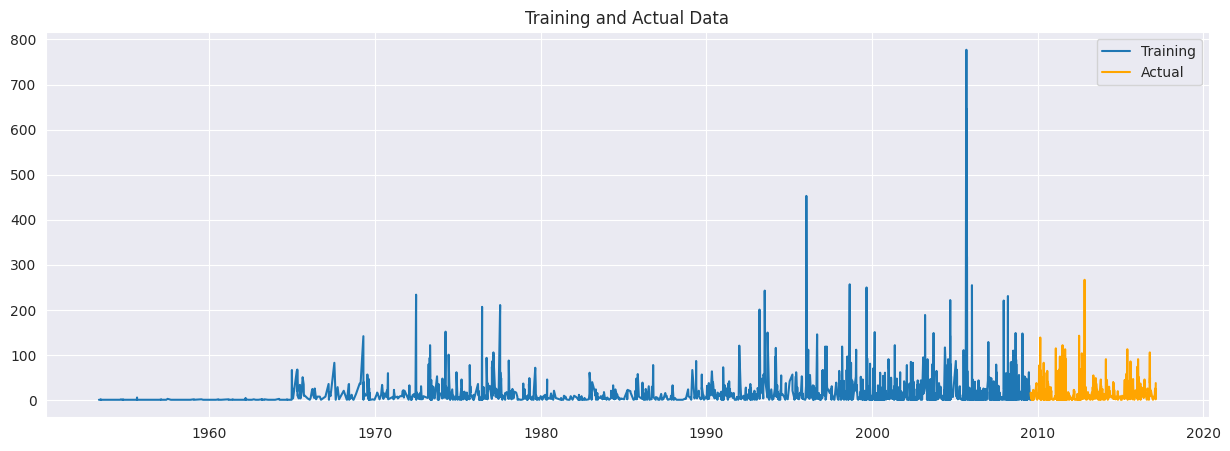

In [88]:
# Assign training and test subsets

daily_ts_data_df = daily_ts_data.to_frame()

print('Dataset dimensions:', daily_ts_data.shape)

# Split data
train_size = int(len(daily_ts_data_df) * 0.8)
train_data, test_data = daily_ts_data_df[:train_size], daily_ts_data_df[train_size:]

print(f"Training data dimension: {train_data.shape} - {round((len(train_data)/len(daily_ts_data_df)*100), 2)}% of dataset")
print(f"Actual data dimension: {test_data.shape} - {round((len(test_data)/len(daily_ts_data_df)*100), 2)}% of dataset")

# Plot training & test data 
plt.figure(figsize=(15, 5))
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Actual', color='orange')
plt.title("Training and Actual Data")
plt.legend();

# Auto ARIMA

In [128]:
# Accuracy metrics
def forecast_accuracy(actual, forecast):
    # Ensure the input arrays are numpy arrays
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # Avoid division by zero by replacing actual values of 0 with a small number
    small_value = 1e-6
    actual_safe = np.where(actual == 0, small_value, actual)

    # Calculate different accuracy metrics
    mape = np.mean(np.abs(actual - forecast) / np.abs(actual_safe))  # MAPE
    me = np.mean(actual - forecast)             # ME
    mae = np.mean(np.abs(actual - forecast))    # MAE
    mpe = np.mean((actual - forecast) / actual_safe)   # MPE
    rmse = np.sqrt(np.mean((actual - forecast) ** 2))  # RMSE

    return {
        'MAPE': mape,
        'ME': me,
        'MAE': mae,
        'MPE': mpe,
        'RMSE': rmse
    }


In [111]:
# Train AUto ARIMA Model 
auto_arima_model = pm.auto_arima(train_data.values, X=None, 
                                 start_p=0, d=None, start_q=0, 
                                 max_p=5, max_d=2, max_q=5, 
                                 start_P=1, D=None, start_Q=1, 
                                 max_P=2, max_D=1, max_Q=2, 
                                 max_order=5, m=12, seasonal=True, 
                                 stationary=False, information_criterion='aic', 
                                 alpha=0.05, test='adf', seasonal_test='ocsb', 
                                 stepwise=True, n_jobs=1, start_params=None, 
                                 trend=None, method='lbfgs', maxiter=300, 
                                 offset_test_args=None, seasonal_test_args=None, 
                                 suppress_warnings=True, error_action='trace', 
                                 trace=True, random=False, random_state=23, 
                                 n_fits=100, return_valid_fits=False, out_of_sample_size=0, 
                                 scoring='mse', scoring_args=None, with_intercept='auto', 
                                 sarimax_kwargs=None)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=20689.191, Time=1.21 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=20686.043, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=20410.596, Time=0.77 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=20527.082, Time=2.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=21034.977, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=20408.686, Time=0.12 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=20410.589, Time=0.58 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=20412.589, Time=1.40 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=20191.715, Time=0.17 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=20193.624, Time=0.93 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=20193.622, Time=1.18 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=20195.621, Time=2.34 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=20193.711, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=20193.705, Time=0.39 sec
 ARIM

In [112]:
# Print the best model found
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2005
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -10091.857
Date:                Tue, 21 Jan 2025   AIC                          20191.715
Time:                        19:42:28   BIC                          20214.128
Sample:                             0   HQIC                         20199.943
                               - 2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.9802      1.242      6.427      0.000       5.547      10.414
ar.L1          0.2445      0.007     36.566      0.000       0.231       0.258
ar.L2          0.3214      0.004     74.826      0.0

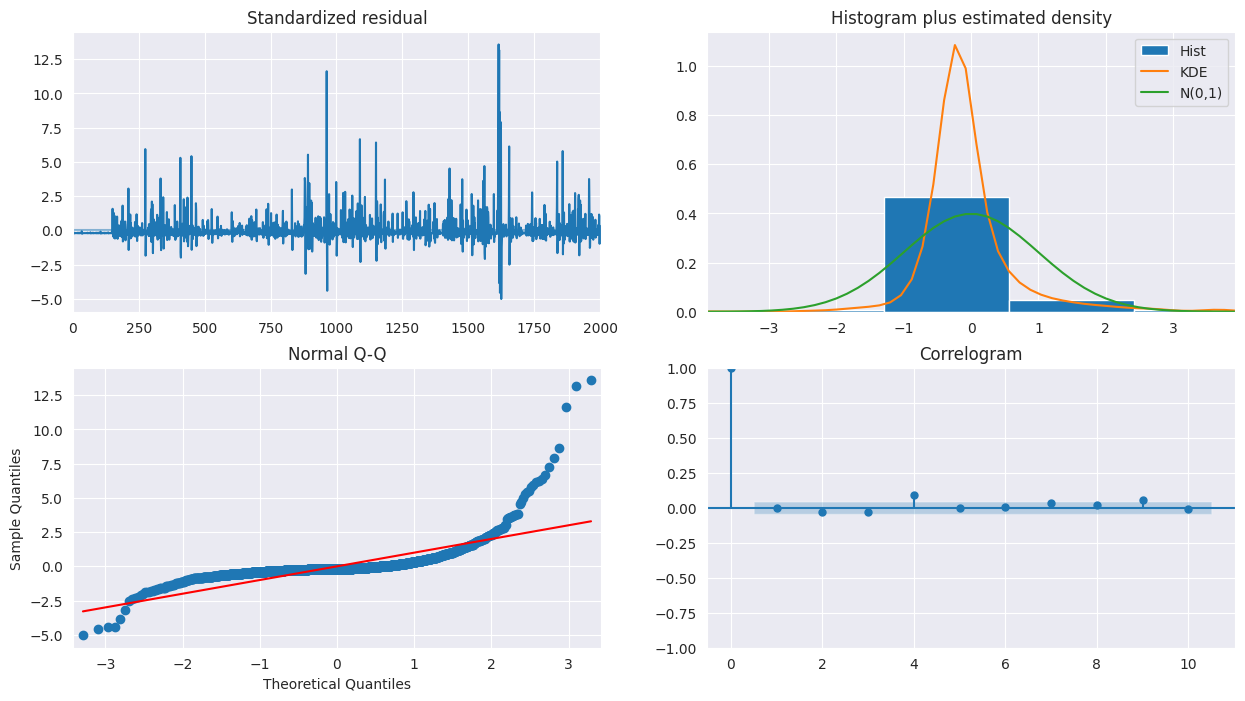

In [113]:
auto_arima_model.plot_diagnostics(figsize=(15, 8));

### Interpretation of plots in plot diagnostics

**Standardized residual:** The residual errors seem to to not fluctuate very well around a mean of zero and have a significant variance.

**Histogram:** The density plot suggest normal distribution.

**Theoretical Quantiles:** Mostly the dots do not fall perfectly in line with the red line. These deviations imply the distribution is skewed.

**Correlogram:** The Correlogram (or ACF plot) examines autocorrelation in the residual errors:
- Since the autocorrelation coefficients fall outside the confidence interval, the residuals are autocorrelated, indicating that the model has not effectively captured the patterns in the data.
- Therefore, additional predictors (X variables) or further model adjustments may be necessary.

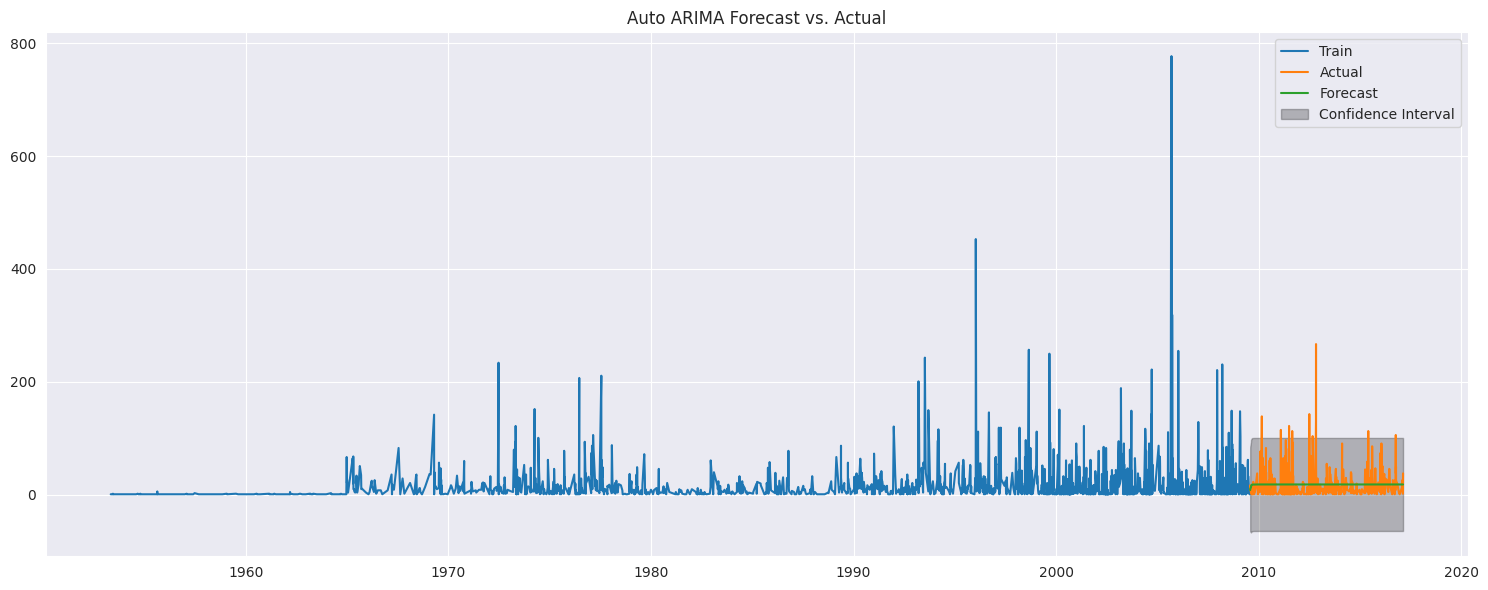

In [116]:
# Forecast
forecast_auto_arima, confint = auto_arima_model.predict(n_periods=test_data.shape[0], return_conf_int=True)

# Create a DataFrame for the forecast
forecast_auto_arima_df = pd.DataFrame(forecast_auto_arima, index=test_data.index, columns=['Forecast'])

# Convert confidence intervals into Series
lower_series = pd.Series(confint[:, 0], index=forecast_auto_arima_df.index)
upper_series = pd.Series(confint[:, 1], index=forecast_auto_arima_df.index)

# Plot training, test, and forecast data
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Actual')
plt.plot(forecast_auto_arima_df, label='Forecast')
plt.fill_between(forecast_auto_arima_df.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.25, label='Confidence Interval')

plt.title("Auto ARIMA Forecast vs. Actual")
plt.legend()
plt.tight_layout();

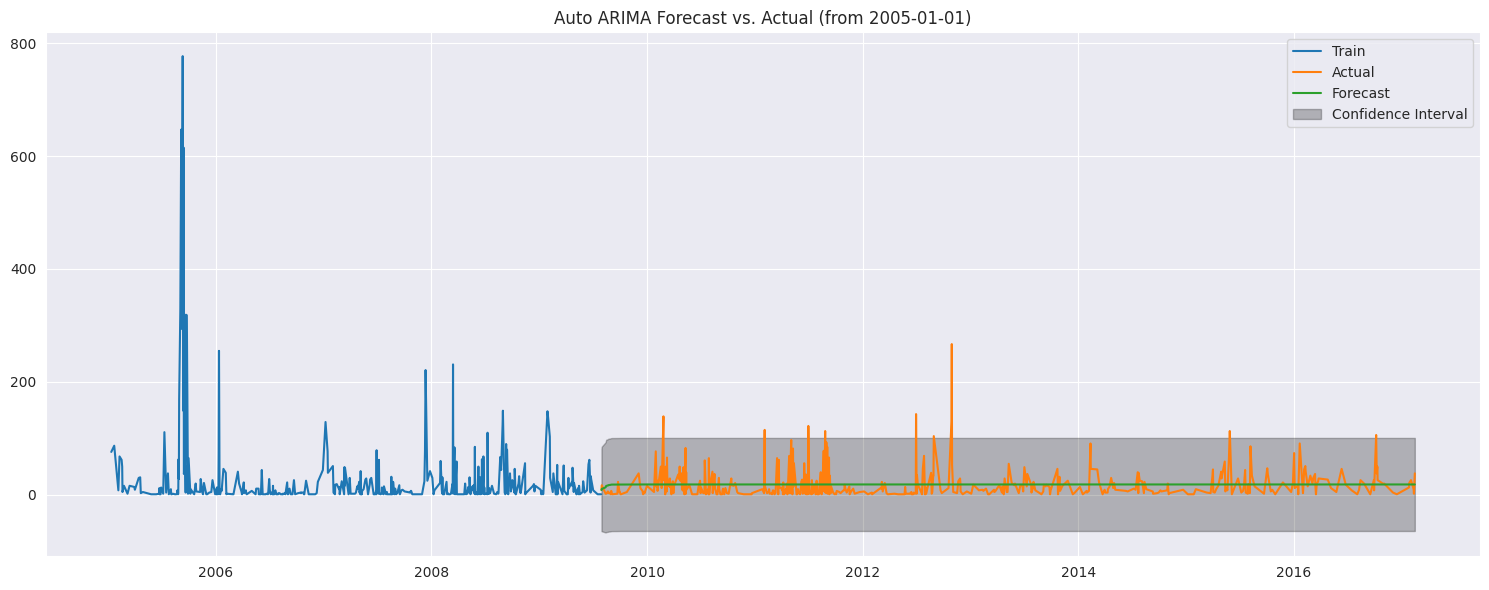

In [126]:
# Define the date range for the subset
start_date = '2005-01-01'

# Slice the data for the specified date range
train_subset = train_data[start_date:]
test_subset = test_data[start_date:]
forecast_subset = forecast_auto_arima_df[start_date:]
lower_subset = lower_series[start_date:]
upper_subset = upper_series[start_date:]

# Plot training, test, and forecast data for the subset
plt.figure(figsize=(15, 6))
plt.plot(train_subset, label='Train')
plt.plot(test_subset, label='Actual')
plt.plot(forecast_subset, label='Forecast')
plt.fill_between(forecast_subset.index, 
                 lower_subset, 
                 upper_subset, 
                 color='k', alpha=.25, label='Confidence Interval')

plt.title(f"Auto ARIMA Forecast vs. Actual (from {start_date})")
plt.legend()
plt.tight_layout();


In [129]:
###############
metrics_auto_arima = forecast_accuracy(test_data.values, forecast_auto_arima)

pd.DataFrame([metrics_auto_arima])

,MAPE,ME,MAE,MPE,RMSE
0,4.249967,0.249193,17.006518,-3.958669,26.053845


# ARIMA

In [54]:
# Function to find the best p, d, q based on AIC 
def best_arima_order(time_series, p_range, d_range, q_range):
    best_aic = np.inf
    best_order = None
    best_model = None

    # Iterate over all combinations of p, d, q
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    # Fit SARIMA model
                    model = sm.tsa.SARIMAX(time_series, order=(p, d, q))
                    model_fit = model.fit(disp=False)

                    # Check AIC
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                        best_model = model_fit
                        
                except Exception as e:
                    # Print or log the error if needed
                    print(f"Failed to fit ARIMA({p},{d},{q}): {e}")
                    continue

    return best_order, best_aic, best_model



# Set range for p, d, q
p_range = range(0, 6)  
d_range = range(0, 3)  
q_range = range(0, 6)  


# Find the best order
best_order, best_aic, best_model = best_arima_order(train_data, p_range, d_range, q_range)


In [55]:
# Output the best parameters and AIC
print(f"Best ARIMA model order: {best_order}")
print(f"Best AIC: {best_aic}")

Best ARIMA model order: (3, 1, 4)
Best AIC: 20168.161977633994


**Rule:** The order of ARIMA should not be more than 10 summed up ($p + d + q \leq 10$)

In [82]:
arima_model = sm.tsa.SARIMAX(train_data.values, order=(3,1,4), seasonal_order=(3,1,4,12))
arima_model_fit = arima_model.fit(disp=False, maxiter=200)

In [83]:
print(arima_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2005
Model:             SARIMAX(3, 1, 4)x(3, 1, 4, 12)   Log Likelihood              -10051.236
Date:                            Tue, 21 Jan 2025   AIC                          20132.472
Time:                                    19:08:47   BIC                          20216.425
Sample:                                         0   HQIC                         20163.304
                                           - 2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8934      0.129     -6.942      0.000      -1.146      -0.641
ar.L2          0.6169      0.022   

In [130]:
# Forecasting
forecast_arima = arima_model_fit.forecast(steps=len(test_data))

# Get metrics
metrics_arima = forecast_accuracy(test_data.values, forecast_arima)

pd.DataFrame([metrics_arima])

,MAPE,ME,MAE,MPE,RMSE
0,6.474068,-8.370167,21.266336,-6.292617,27.625291


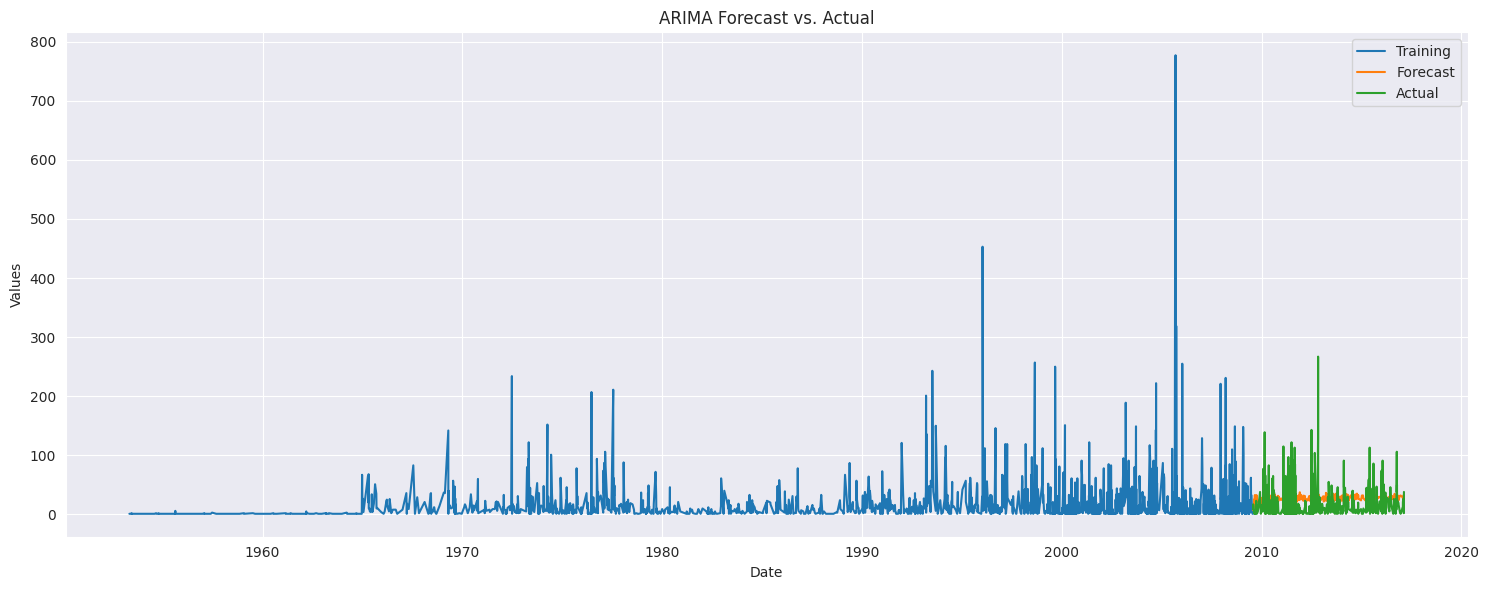

In [124]:
# Plot the training, actual and predicted data
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Training')
plt.plot(test_data.index, forecast_arima, label='Forecast',)
plt.plot(test_data, label='Actual')
plt.title("ARIMA Forecast vs. Actual")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.tight_layout();


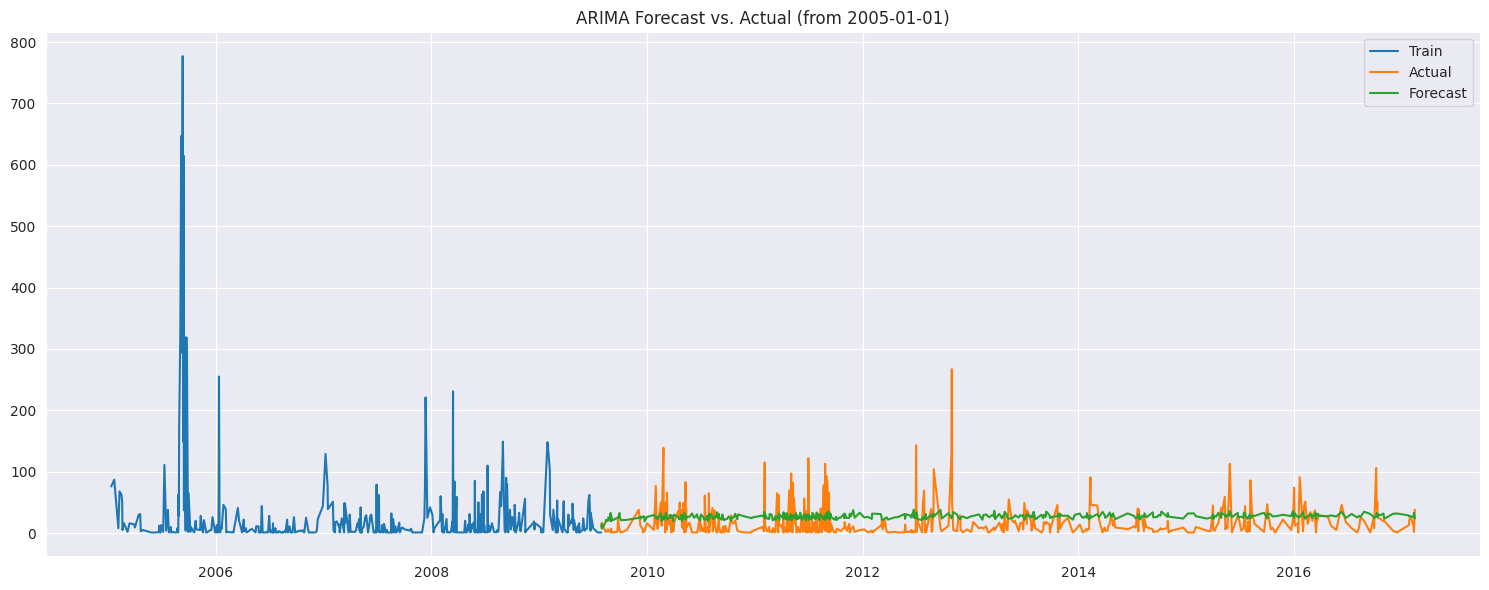

In [127]:
forecast_arima_df = pd.DataFrame(forecast_arima, index=test_data.index, columns=['Forecast'])

# Define the date range for the subset
start_date = '2005-01-01'

# Slice the data for the specified date range
train_subset1 = train_data[start_date:]
test_subset1 = test_data[start_date:]
forecast_subset1 = forecast_arima_df[start_date:]

# Plot training, test, and forecast data for the subset
plt.figure(figsize=(15, 6))
plt.plot(train_subset1, label='Train')
plt.plot(test_subset1, label='Actual')
plt.plot(forecast_subset1, label='Forecast')
plt.title(f"ARIMA Forecast vs. Actual (from {start_date})")
plt.legend()
plt.tight_layout();

As we can see, ARIMA is not performing well, so we will try using machine learning models instead.